In [1]:
# !pip install pyLDAvis

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
from bs4 import BeautifulSoup
import requests
from gensim import models, corpora
import pandas as pd
from tqdm import tqdm
from nltk import RegexpTokenizer
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud

pages = 20
site_list = []

# 사이트 주소 수집
for page_num in range(1,pages+1):
    response = requests.get(f'https://www.hankyung.com/economy/macro?page={page_num}')
    soup = BeautifulSoup(response.text, 'html.parser')
    if len(soup.select('h2.news-tit')) !=0:
        site_soup = soup.select('h2.news-tit')
        for i in site_soup:
            site_list.append(i.select_one('a').get('href'))      
    else:
        break

# 본문 수집하여 넣을 딕셔너리
article_dict = {'title':[],'article':[]}

# 수집 실패한 주소 리스트
fail_list = []

# 본문 수집
for site in tqdm(site_list):
    try:
        site_response = requests.get(site)
        article_soup = BeautifulSoup(site_response.text, 'html.parser')
        
        # 제목 수집
        headline = article_soup.select_one('h1.headline').text
        headline = ' '.join(headline.split())  # 공백, 탭, 개행 제거
        
        # 본문 수집
        article = article_soup.select_one('div.article-body').text
        article = ' '.join(article.split())

        # 수집한 값 추가
        article_dict['title'].append(headline)
        article_dict['article'].append(article)
    
    except:
        # 수집 실패했을 경우
        fail_list.append(site)
        continue

df = pd.DataFrame(article_dict)
df

c:\Users\ENVY\anaconda3\envs\study\lib\site-packages\matplotlib\__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\Users\ENVY\anaconda3\envs\study\lib\site-packages\setuptools\_distutils\version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\Users\ENVY\anaconda3\envs\study\lib\site-packages\matplotlib\__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\Users\ENVY\anaconda3\envs\study\lib\site-packages\setuptools\_distutils\version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\Users\ENVY\anaconda3\envs\study\lib\site-packages\matplotlib\__init__.py:169: DeprecationWarning: distutils Version classes a

,title,article
0,4분기 성장률도 5분의1토막…연간 '2.0%' 턱걸이,탄핵 정국 여파로 내수가 위축돼 올해 한국 경제 성장률이 1.3%까지 떨어질 수 있...
1,"자본연 ""올해 韓성장률 1.6% 전망…상장사 실적 하향 우려""",자본시장연구원은 22일 오후 여의도 금투센터에서 '2025년 자본시장 전망과 주요 ...
2,이창용에 추경 따진 권성동 … 정치에 휩쓸린 한은,권성동 국민의힘 원내대표가 22일 한국은행을 방문해 추가경정예산안 편성 필요성을 강...
3,외출할 때 반려견 목줄 착용 하나요? 반려인·비반려인 물었더니,지난해 10월 서울 송파구 탄천유수지 반려견놀이터에서 '송파 반려동물 한마당'이 열...
4,"육지만큼 뜨거웠던 바다…작년 한국 표층수온, 관측 사상 가장 높았다",지난해 8월 늦은 저녁 서울 여의도한강공원에서 시민들이 더위를 식히고 있는 모습. ...
...,...,...
344,내수 부진 쇼크…코로나 이후 첫 '역성장',올해 2분기 우리나라 경제가 코로나19 기간 이후 1년6개월 만에 처음으로 역성장했...
345,"中, 기준금리 이어 정책금리도 인하",중국이 둔화한 경기를 되살리기 위해 연일 통화정책 완화에 나서고 있다. ‘깜짝 기준...
346,"""경제 망한 것 아니다, 코로나 때와 달라""…한은의 항변 [강진규의 BOK워치]",신승철 한국은행 경제통계국장이 25일 2분기 실질 국내총생산(GDP) 속보치가 -0...
347,내수·수출 동반 부진…2분기 GDP -0.2% '역성장',사진=연합뉴스 내수와 수출이 주춤한 모습을 보이면서 2분기 국내총생산(GDP)이 역...


In [10]:
tokenizer = RegexpTokenizer(r'[가-힣]+')
stop_words = list(set(('이','은','는','이','가')))

def preprocess_text(text):
    tokens = tokenizer.tokenize(text)

    # 불용어 처리
    tokens = [word for word in tokens if word not in stop_words and len(word)>2]

    return tokens

df['tokens'] = df['article'].apply(preprocess_text)

dictionary = corpora.Dictionary(df['tokens'])
corpuse = [dictionary.doc2bow(token) for token in df['tokens']]

tfidf_model = models.TfidfModel(corpuse)
corpuse_tfidf = tfidf_model[corpuse]

lda_model = models.LdaModel(corpuse_tfidf,
                            passes=10,
                            id2word=dictionary,
                            random_state=42,
                            num_topics=3)
lda_model

In [19]:
# 문서별 토픽 중요도
lda_model[corpuse_tfidf][0]

[(0, 0.9474461), (1, 0.026708148), (2, 0.025845699)]

In [12]:
# 토픽 아이디별 탑10개
lda_model.show_topic(topicid=0,topn=10)

[('포인트', 0.00069525786),
 ('금리를', 0.0004528419),
 ('트럼프', 0.00044439503),
 ('성장률', 0.0004175252),
 ('총재는', 0.00040716745),
 ('지난달', 0.00038724925),
 ('한은은', 0.00037493967),
 ('금리는', 0.0003374149),
 ('것으로', 0.00033414358),
 ('전망치를', 0.00032107343)]

In [13]:
pyldavis_prepared = gensimvis.prepare(lda_model, corpuse, dictionary)
pyLDAvis.display(pyldavis_prepared)

c:\Users\ENVY\anaconda3\envs\study\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [14]:
# # 한글 폰트 설치
# !apt-get update -qq
# !apt-get install fonts-nanum -qq

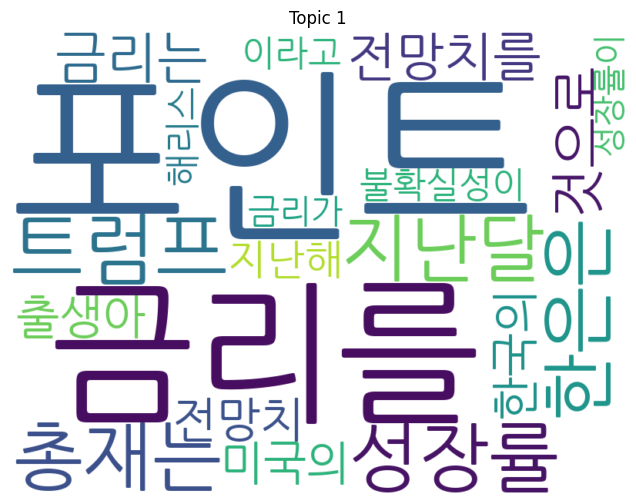

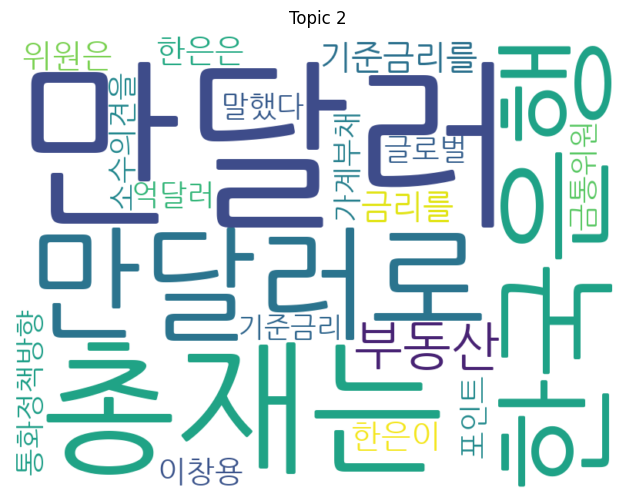

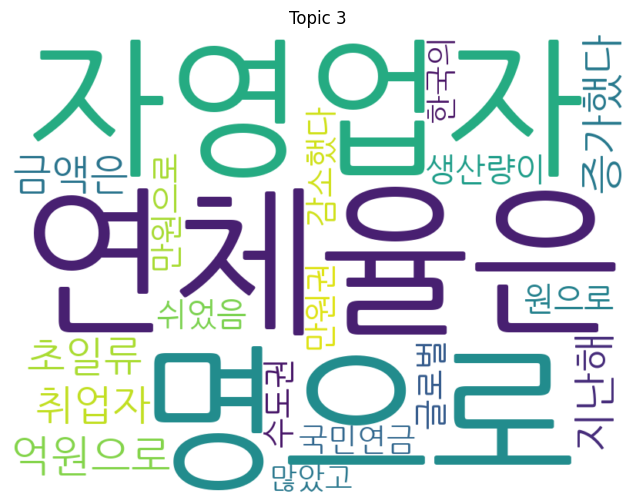

In [15]:
%matplotlib inline

num_topics = 3

# 각 토픽에 대한 워드클라우드 생성
for topic_id in range(num_topics):
    plt.figure(figsize=(8, 6))

    # 토픽별 단어 추출
    topic_words = lda_model.show_topic(topic_id, topn=20)
    word_freq = {word: freq for word, freq in topic_words}

    # 워드클라우드 생성
    wordcloud = WordCloud(width=800, 
                          height=600,
                          font_path="C:/Windows/Fonts/NanumGothic.ttf",  # 나눔고딕 폰트 경로 추가 
                          background_color="white").generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_id + 1}")
    plt.show()